# Modules

In [113]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.precision", 4)

# Data

In [56]:
valores_missing = ['', ' ']
gasto = pd.read_csv("conjunto_de_datos_gastoshogar_enigh_2018_ns.csv", \
                    usecols= [0,1,14], na_values = valores_missing)

In [57]:
gasto.head()

,folioviv,foliohog,gasto
0,100013601,1,30.0
1,100013601,1,84.0
2,100013601,1,60.0
3,100013601,1,33.0
4,100013601,1,2400.0


In [58]:
valores_missing = ['', ' ']
hogares = pd.read_csv("conjunto_de_datos_hogares_enigh_2018_ns.csv", \
                    index_col= [0,1], \
                    usecols= [0, 1, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, \
                              41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, \
                              77, 79, 81, 83, 85, 87, 89, 91, 93, 95], \
                      na_values = valores_missing)

In [59]:
hogares.head()

,,alim17_1,alim17_2,alim17_3,alim17_4,alim17_5,alim17_6,alim17_7,alim17_8,alim17_9,alim17_10,...,num_refri,num_estuf,num_lavad,num_planc,num_maqui,num_venti,num_aspir,num_compu,num_impre,num_juego
folioviv,foliohog,,,,,,,,,,,,,,,,,,,,,
100013601,1,7,1,7,7,4,7,1,7,7,7,...,1.0,1.0,1.0,1.0,1,1.0,1,1,0,0
100013602,1,7,3,4,3,3,2,0,5,7,5,...,1.0,1.0,1.0,1.0,1,1.0,1,2,1,1
100013603,1,4,2,5,4,5,3,2,2,3,4,...,1.0,1.0,1.0,1.0,0,1.0,0,1,0,0
100013604,1,7,3,7,7,4,7,1,5,2,7,...,1.0,1.0,1.0,1.0,1,5.0,0,0,0,0
100013606,1,7,1,1,7,3,7,0,2,7,7,...,1.0,1.0,1.0,1.0,0,0.0,0,0,0,0


# Preprocessing

## Household Spending

Podemos ver que hay viviendas con varios hogares, entonces hay que verificar si no se tienen hogares repetidos

In [60]:
gasto_x_hogar =gasto.groupby(['folioviv','foliohog']).sum()
gasto_x_hogar.head()

,,gasto
folioviv,foliohog,
100013601,1,2607.0
100013602,1,23696.0
100013603,1,38780.0
100013604,1,7428.0
100013606,1,2547.0


### High spending per household

In [61]:
gasto_x_hogar.describe(percentiles= [.25,.5,.75,.80,.85])

,gasto
count,4.4250e+04
mean,1.1337e+04
std,2.8322e+04
min,6.0000e+00
25%,2.1012e+03
50%,4.7080e+03
75%,1.0843e+04
80%,1.3539e+04
85%,1.7657e+04
max,1.3569e+06


array([[<AxesSubplot: title={'center': 'gasto'}>]], dtype=object)

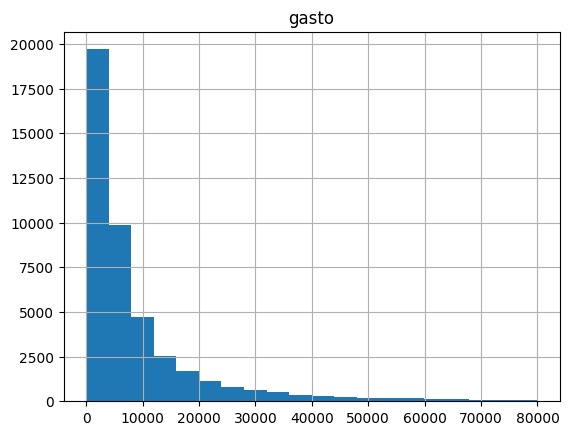

In [62]:
gasto_x_hogar[gasto_x_hogar["gasto"]<80000].hist(bins= 20)

Como logramos observar la mayoria de los hogares tiene un gasto monetario al mes entre $\$2,000-\$20,000$, por lo cual $\$25,000$ es un gasto alto que no es alcanzado por mas del $85\%$ de la muestra, pero con fines de utilizarlo en la generación de canastas lo abordarmeos lo que gasta el 25% más alto que es al rededor de $\$13,000$

In [63]:
ingreso_alto= 13000

In [64]:
gasto_x_hogar['ingreso_alto'] = gasto_x_hogar['gasto'].map(lambda x: x > ingreso_alto)
del gasto_x_hogar['gasto']

In [65]:
gasto_x_hogar.head(5)

,,ingreso_alto
folioviv,foliohog,
100013601,1,False
100013602,1,True
100013603,1,True
100013604,1,False
100013606,1,False


## Description of households

In [66]:
hogares_bool = hogares > 0

In [67]:
union = hogares_bool.merge(gasto_x_hogar, how='left', left_index=True, right_index=True)
union.shape

(74647, 46)

## Missings

In [68]:
datos = union[union.ingreso_alto.notnull()]
datos["ingreso_alto"] = datos["ingreso_alto"].astype(bool)
datos.shape

/tmp/ipykernel_103/267429510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos["ingreso_alto"] = datos["ingreso_alto"].astype(bool)


(44250, 46)

# Frequent items

In [69]:
datos_muestra = datos.sample(n=10000, random_state = 202011)

## Support=.7, Max_lenght=4

In [94]:
frequent_itemsets = apriori(datos, 
                            min_support =.7, 
                            max_len = 4, 
                            use_colnames = True) 

In [95]:
print(frequent_itemsets.shape)
frequent_itemsets.tail()

(4124, 2)


,support,itemsets
4119,0.8407,"(num_estuf, conex_inte, num_refri, tv_paga)"
4120,0.7053,"(num_planc, conex_inte, num_refri, tv_paga)"
4121,0.7182,"(num_estuf, num_planc, conex_inte, tv_paga)"
4122,0.7834,"(num_estuf, num_licua, num_refri, tv_paga)"
4123,0.7834,"(num_estuf, num_licua, num_refri, conex_inte)"


### Association_rules

In [96]:
rules = association_rules(frequent_itemsets, 
                          metric = 'confidence', 
                          min_threshold =.5 )

In [97]:
print(rules.shape)
rules.head()

(48300, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(alim17_2),(alim17_1),0.8366,0.9955,0.8351,0.9982,1.0028,0.0023,2.5869
1,(alim17_1),(alim17_2),0.9955,0.8366,0.8351,0.8389,1.0028,0.0023,1.0145
2,(alim17_3),(alim17_1),0.9431,0.9955,0.9410,0.9977,1.0023,0.0021,1.9954
3,(alim17_1),(alim17_3),0.9955,0.9431,0.9410,0.9453,1.0023,0.0021,1.0392
4,(alim17_4),(alim17_1),0.8957,0.9955,0.8934,0.9974,1.0020,0.0018,1.7651


In [74]:
rules_income_consecuent = rules[rules['consequents'] == {'ingreso_alto'}]
rules_income_consecuent.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


## Support=.8, Max_lenght=5

In [105]:
frequent_itemsets = apriori(datos, 
                            min_support =.8, #Inserta valor 
                            max_len = 5, #Inserta valor
                            use_colnames = True) 

In [99]:
print(frequent_itemsets.shape)
frequent_itemsets.tail()

(4519, 2)


,support,itemsets
4514,0.8268,"(conex_inte, telefono, num_licua, tv_paga, num..."
4515,0.8407,"(conex_inte, num_refri, telefono, tv_paga, num..."
4516,0.8112,"(conex_inte, num_refri, num_licua, celular, tv..."
4517,0.8268,"(conex_inte, num_licua, celular, tv_paga, num_..."
4518,0.8407,"(conex_inte, num_refri, celular, tv_paga, num_..."


### Association_rules

In [106]:
rules = association_rules(frequent_itemsets, 
                          metric = 'support', 
                          min_threshold =.7 )

In [107]:
print(rules.shape)
rules.head()

(93146, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(alim17_2),(alim17_1),0.8366,0.9955,0.8351,0.9982,1.0028,0.0023,2.5869
1,(alim17_1),(alim17_2),0.9955,0.8366,0.8351,0.8389,1.0028,0.0023,1.0145
2,(alim17_3),(alim17_1),0.9431,0.9955,0.9410,0.9977,1.0023,0.0021,1.9954
3,(alim17_1),(alim17_3),0.9955,0.9431,0.9410,0.9453,1.0023,0.0021,1.0392
4,(alim17_4),(alim17_1),0.8957,0.9955,0.8934,0.9974,1.0020,0.0018,1.7651


In [102]:
rules_income_consecuent = rules[rules['consequents'] == {'ingreso_alto'}]
rules_income_consecuent.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


## Support=.2, Max_lenght=3

In [108]:
frequent_itemsets = apriori(datos, 
                            min_support =.2, #Inserta valor 
                            max_len = 2, #Inserta valor
                            use_colnames = True) 

In [109]:
print(frequent_itemsets.shape)
frequent_itemsets.tail()

(430, 2)


,support,itemsets
425,0.5868,"(num_planc, num_lavad)"
426,0.4249,"(num_venti, num_lavad)"
427,0.2157,"(num_lavad, num_compu)"
428,0.4358,"(num_planc, num_venti)"
429,0.2226,"(num_planc, num_compu)"


### Association_rules

In [110]:
rules = association_rules(frequent_itemsets, 
                          metric = 'lift', 
                          min_threshold =.7 )

In [111]:
print(rules.shape)
rules.head()

(798, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(alim17_2),(alim17_1),0.8366,0.9955,0.8351,0.9982,1.0028,0.0023,2.5869
1,(alim17_1),(alim17_2),0.9955,0.8366,0.8351,0.8389,1.0028,0.0023,1.0145
2,(alim17_3),(alim17_1),0.9431,0.9955,0.9410,0.9977,1.0023,0.0021,1.9954
3,(alim17_1),(alim17_3),0.9955,0.9431,0.9410,0.9453,1.0023,0.0021,1.0392
4,(alim17_4),(alim17_1),0.8957,0.9955,0.8934,0.9974,1.0020,0.0018,1.7651


In [117]:
rules_income_consecuent = rules[rules['consequents'] == {'ingreso_alto'}]
rules_income_consecuent

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
58,(alim17_1),(ingreso_alto),0.9955,0.2083,0.2069,0.2078,0.9976,-0.0005,0.9994
166,(alim17_3),(ingreso_alto),0.9431,0.2083,0.2028,0.2150,1.0321,0.0063,1.0085
266,(alim17_5),(ingreso_alto),0.9256,0.2083,0.2025,0.2187,1.0500,0.0096,1.0133
392,(alim17_8),(ingreso_alto),0.9665,0.2083,0.2003,0.2073,0.9949,-0.0010,0.9987
474,(alim17_10),(ingreso_alto),0.9858,0.2083,0.2057,0.2087,1.0016,0.0003,1.0004
581,(telefono),(ingreso_alto),1.0000,0.2083,0.2083,0.2083,1.0000,0.0000,1.0000
614,(celular),(ingreso_alto),1.0000,0.2083,0.2083,0.2083,1.0000,0.0000,1.0000
646,(tv_paga),(ingreso_alto),1.0000,0.2083,0.2083,0.2083,1.0000,0.0000,1.0000
676,(conex_inte),(ingreso_alto),1.0000,0.2083,0.2083,0.2083,1.0000,0.0000,1.0000
786,(num_estuf),(ingreso_alto),0.9033,0.2083,0.2005,0.2220,1.0656,0.0124,1.0176


#### Visualization

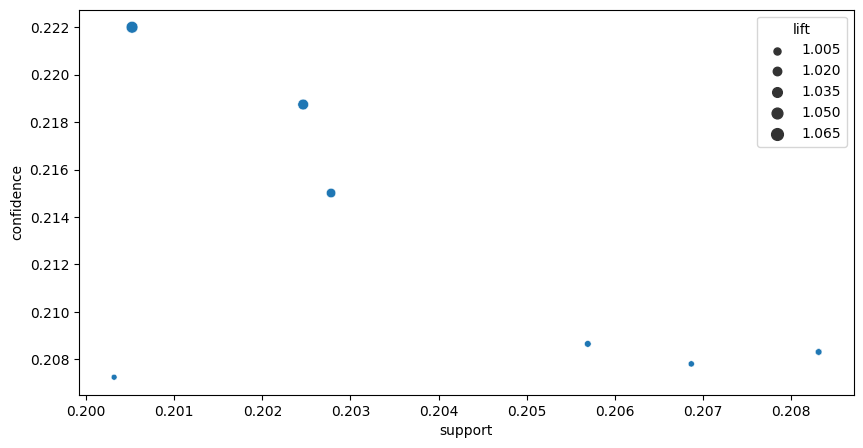

In [119]:
plt.figure(figsize=(10,5))
sns.scatterplot(x = "support", y = "confidence", size = "lift", data = rules_income_consecuent)

plt.show()

In [120]:
filtered_rules = rules_income_consecuent[(rules_income_consecuent['support'] > .2) &  
                (rules_income_consecuent['confidence'] > .208) & # Modifica el valor
                (rules_income_consecuent['lift'] >= 1.03)] # Modifica el valor

In [121]:
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
166,(alim17_3),(ingreso_alto),0.9431,0.2083,0.2028,0.2150,1.0321,0.0063,1.0085
266,(alim17_5),(ingreso_alto),0.9256,0.2083,0.2025,0.2187,1.0500,0.0096,1.0133
786,(num_estuf),(ingreso_alto),0.9033,0.2083,0.2005,0.2220,1.0656,0.0124,1.0176


## Finding

Como podemos ver la busqueda de elemenentos frequentes en donde se tiene ingreso alto, tiene que tener un soporte bajo porque hay poca población con esos gastos al mes. Ahora se logra notar que las reglas en cuanto a su antecedente depende mucho de tener un soporte grande y eso incluye a elementos que tendrán los demás hogares; dejando eso de lado tenemos que los hogares con un ingreso alto son consequentes de:  

- Consumir carne en la semana  
- Tener internet
- Tener celular y telefono
- Tener cable  

Cabe resaltar que al borrar la cantidad de veces que lo hacen pues tenemos menos factores para segmentar y por ende los antecedentes pueden sonar alcanzables para cualquier hogar.

## Metrica Zhang T

$$zhang(A \to B) = \frac{support(A \cup B) - support(A)*support(B)}{max[support(A \cup B)*(1 - support(A)),support(A)*(support(B) - support(A \cup B))]}$$

In [150]:
def zhangT(x):
    numerador= x[4]-(x[2]*x[3])
    a=x[4]*(1-x[2])
    b=x[2]*(x[3]-x[4])
    denominador = max(a,b) 
    if(denominador==0):
        return 0
    return numerador/denominador

In [151]:
rules_income_consecuent["zhangT"] = rules_income_consecuent.apply(lambda x: zhangT(x), axis=1)

/tmp/ipykernel_103/4247575054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_income_consecuent["zhangT"] = rules_income_consecuent.apply(lambda x: zhangT(x), axis=1)


In [152]:
rules_income_consecuent

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangT
58,(alim17_1),(ingreso_alto),0.9955,0.2083,0.2069,0.2078,0.9976,-0.0005,0.9994,-0.3473
166,(alim17_3),(ingreso_alto),0.9431,0.2083,0.2028,0.2150,1.0321,0.0063,1.0085,0.5473
266,(alim17_5),(ingreso_alto),0.9256,0.2083,0.2025,0.2187,1.0500,0.0096,1.0133,0.6403
392,(alim17_8),(ingreso_alto),0.9665,0.2083,0.2003,0.2073,0.9949,-0.0010,0.9987,-0.1329
474,(alim17_10),(ingreso_alto),0.9858,0.2083,0.2057,0.2087,1.0016,0.0003,1.0004,0.1147
581,(telefono),(ingreso_alto),1.0000,0.2083,0.2083,0.2083,1.0000,0.0000,1.0000,0.0000
614,(celular),(ingreso_alto),1.0000,0.2083,0.2083,0.2083,1.0000,0.0000,1.0000,0.0000
646,(tv_paga),(ingreso_alto),1.0000,0.2083,0.2083,0.2083,1.0000,0.0000,1.0000,0.0000
676,(conex_inte),(ingreso_alto),1.0000,0.2083,0.2083,0.2083,1.0000,0.0000,1.0000,0.0000
786,(num_estuf),(ingreso_alto),0.9033,0.2083,0.2005,0.2220,1.0656,0.0124,1.0176,0.6369


Con esta nueva metrica podemos notar que reglas tienen una asociación positiva,negativa o no tiene relación ante el ingreso alto, por lo cual dividimos en:  
- *Asociación positiva:* Indicadores de que al cumplir esta condición, esta asociado a un ingreso alto
    - Consumir carne  
    - Tener estufa
- *Asociaón negativa:* Indicadores que al cumplirse pueden sugerir un ingreso no alto
    - Consumir derivados de maíz (tortillas por ejemplo)
    - Consumir leguminosas o semillas (Frijol,grabanzo,..)
    